In [52]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df= pd.read_csv("./전처리/df_stock2.csv")
df_stock = df.drop(['Unnamed: 0','Code'],axis = 1)

# 1월3일의 결과를 1월 2일의 기사를 토대로 예측해야 하므로 한칸 위로
df_stock['target']=df_stock['label'].shift(-1)
# shift가 발생하면서 1월2일의 라벨들이 12월 30이롤 이동하기 때문에 삭제
check = (df_stock['Date'] == '2019-12-30')
# ~ 기호를 이용하여, 해당하지 않은 데이터만 남긴다
df_stock = df_stock[~check]

# 라벨인코딩을 통해서, 해당 타겟 값을 바꿔준다.
encoder = LabelEncoder()
encoder.fit(df_stock['target'])
labels = encoder.transform(df_stock['target'])
df_stock['target'] = labels

In [53]:
# head - feature 500
df_news = pd.read_csv('./전처리/TF-IDF/head_tf-idf_500.csv')
df_stock['Date'] = df_stock['Date'].str.replace('-','.')
df_stock['id'] = df_stock['Name']+df_stock['Date']
df_news['id'] = df_news['Company']+df_news['Day']
total_df = pd.merge(df_stock, df_news, on = 'id').drop(['Name','Date','id','Company','Day','Unnamed: 0','label'],axis=1)
total_df = total_df.dropna()
target = total_df['target']
test = total_df.drop(['target'], axis=1)

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(test, target, test_size=0.3, shuffle=False, random_state=100)

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.7689176967138981


In [54]:
import eli5
from eli5.sklearn  import PermutationImportance

perm1 = PermutationImportance(lr_clf, scoring = "f1", random_state = 42).fit(X_test, y_test)
eli5.show_weights(perm1, top = 80, feature_names = X_test.columns.tolist())

Weight,Feature
0.0021 ± 0.0013,총수
0.0013 ± 0.0000,거래
0.0013 ± 0.0000,논란
0.0013 ± 0.0000,전일
0.0013 ± 0.0000,특별
0.0013 ± 0.0000,연봉
0.0013 ± 0.0000,업계
0.0013 ± 0.0000,최태원
0.0010 ± 0.0010,기대
0.0010 ± 0.0010,개선


In [56]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred):
    print("오차 행렬\n", confusion_matrix(y_test, pred))
    print("정확도 : ", accuracy_score(y_test, pred))
    print("정밀도 : ", precision_score(y_test, pred))
    print("재현율 : ", recall_score(y_test, pred))
    print("f1 : ", f1_score(y_test,pred))
    print("roc : ", roc_auc_score(y_test,pred))
get_clf_eval(y_test, pred)

오차 행렬
 [[5099    5]
 [1528    2]]
정확도 :  0.7689176967138981
정밀도 :  0.2857142857142857
재현율 :  0.00130718954248366
f1 :  0.002602472348731295
roc :  0.5001637828590161


In [57]:
import numpy as np

pred_proba = lr_clf.predict_proba(X_test) # 각 결과의 대한 예측 확률
pred = lr_clf.predict(X_test)
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis = 1) 
df_proba = pd.DataFrame(pred_proba_result)
df_proba

,0,1,2
0,0.823208,0.176792,0.0
1,0.794033,0.205967,0.0
2,0.811164,0.188836,0.0
3,0.799313,0.200687,0.0
4,0.892953,0.107047,0.0
...,...,...,...
6629,0.832936,0.167064,0.0
6630,0.760999,0.239001,0.0
6631,0.733540,0.266460,0.0
6632,0.721514,0.278486,0.0


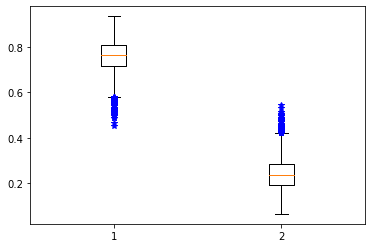

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['figure.figsize'] = [10, 6]

%matplotlib inline

fig, ax = plt.subplots()
ax.boxplot([df_proba[0], df_proba[1]], sym="b*")

plt.xticks([1, 2])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

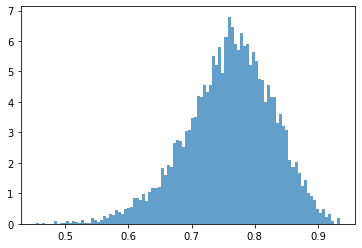

In [59]:
# 0을 예측하는 확률의 분포
plt.hist(df_proba[0], bins=100, density=True, alpha=0.7, histtype='stepfilled')
plt.show

In [49]:
from sklearn.preprocessing import Binarizer

thresholds = [0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55]

def get_eval_by_threshold(y_test, pred_proba, thresholds):
    for custom in thresholds:
        binarizer = Binarizer(threshold=custom).fit(pred_proba)
        custom_predict = binarizer.transform(pred_proba)
        print(f"임곗값 : {custom}")
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값 : 0.2
오차 행렬
 [[1511 3593]
 [ 423 1107]]
정확도 :  0.3946337051552608
정밀도 :  0.23553191489361702
재현율 :  0.7235294117647059
f1 :  0.35537720706260034
roc :  0.5097858657569612
임곗값 : 0.25
오차 행렬
 [[3036 2068]
 [ 854  676]]
정확도 :  0.5595417545975279
정밀도 :  0.24635568513119532
재현율 :  0.4418300653594771
f1 :  0.31633130556855404
roc :  0.5183288257831868
임곗값 : 0.3
오차 행렬
 [[4183  921]
 [1231  299]]
정확도 :  0.6756104914078988
정밀도 :  0.24508196721311476
재현율 :  0.1954248366013072
f1 :  0.21745454545454546
roc :  0.5074890640686787
임곗값 : 0.35
오차 행렬
 [[4778  326]
 [1425  105]]
정확도 :  0.736056677720832
정밀도 :  0.24361948955916474
재현율 :  0.06862745098039216
f1 :  0.10708822029576746
roc :  0.5023779888130802
임곗값 : 0.4
오차 행렬
 [[5004  100]
 [1502   28]]
정확도 :  0.758516731986735
정밀도 :  0.21875
재현율 :  0.018300653594771243
f1 :  0.03377563329312425
roc :  0.4993540885528715
임곗값 : 0.45
오차 행렬
 [[5078   26]
 [1523    7]]
정확도 :  0.7665058788061502
정밀도 :  0.21212121212121213
재현율 :  0.004575163398692811
f1 :  0.

C:\Users\gimhu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


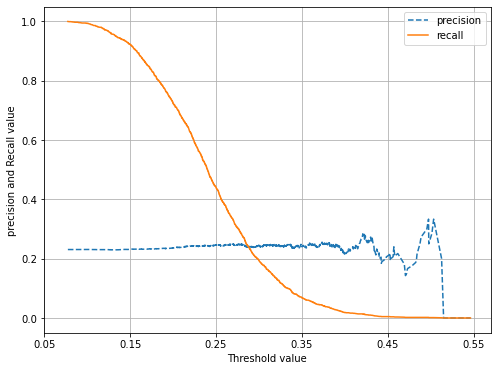

In [61]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    plt.figure(figsize = (8,6))
    # x축 범위 설정
    threshold_boundary = thresholds.shape[0]
    
    #정밀도와 재현율 시각화
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start,end =plt.xlim()
    # x축 설정
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold value');
    plt.ylabel('precision and Recall value')
    plt.legend();
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])